In [ ]:
using Requests
import Requests: get

using JSON

clientid = "da6d5e5415582a69b4dc18c5f8d58e2e"
baseapi = "http://api.soundcloud.com"

# Get Soundcloud user id given user url
function resolveuser(url::AbstractString)
    req = Requests.get(
        joinpath(baseapi,"resolve?"),
        query = Dict("client_id" => clientid,"url" => url)
    )
    res = Requests.json(req)
    userid = res["id"]
    println(userid)
    return userid
end

# Recursively call through Soundcloud API linked partition data
function getlinkedpartition(res::Dict, collection::Array)
#    println(length(collection))
    if haskey(res,"collection")
        nextcollection = res["collection"]
    else
        return collection
    end
#    println(nextcollection)
    if !isequal(length(nextcollection),0)
        push!(collection, nextcollection...)
    end
    # Check if it has href for more data
    if haskey(res, "next_href")
        print(".")
        next_href = res["next_href"]
        if isequal(next_href,nothing)
            # No more hrefs
            return collection
        else
            # Recursively get next partition of data
            req = Requests.get(next_href)
            res = Requests.json(req)
            return getlinkedpartition(res, collection)
        end
    else
        # Return if no data
        println("Total objects found: ", length(collection))
        return collection
    end
end


# Recursively download each track in an array
function downloadtracks(tracks::Array)
  if !isempty(tracks)
    track = pop!(tracks)
#     if !isequal(track["artwork_url"], Void())
    artworkurl = track["artwork_url"]
    if !isequal(artworkurl, Void())
        try
            
#             highres = replace(track["artwork_url"], "large", size)
                artwork = Requests.get(artworkurl)
#       Requests.save(artwork, "$(track["title"]).jpg")
                Requests.save(artwork, replace(artworkurl, "https://i1.sndcdn.com/", ""))
        catch
        end
    end
    downloadtracks(tracks)
  end
end


# SCRAPE FAVORITES
function scrapefavorites(userid::Integer=49699208)
    println("\tConnecting to Soundcloud for favorites")
    req = Requests.get(
        joinpath(baseapi,"users",string(userid),"favorites"),
        query = Dict("client_id" => clientid, "linked_partitioning" => "1")
    )
    res = Requests.json(req)
    favorites = getlinkedpartition(res, [])
    cd(() -> downloadtracks(favorites), "favorites")
end

# SCRAPE PLAYLISTS
function scrapeplaylists(userid::Integer=49699208, format::Regex=r"\[[0-9]{2}\.[0-9]{2}\.[0-9]{2}\]")
    if isequal(userid, 49699208)
        println("phamartin")
        format = r"\[[0-9]{2}\.[0-9]{2}\.[0-9]{2}\]"
    end
    println("Connecting to Soundcloud for playlists")
    req = Requests.get(
        joinpath(baseapi,"users",string(userid),"playlists"),
        query = Dict("client_id" => clientid, "linked_partitioning" => "1")
    )
    res = Requests.json(req)
    playlists = getlinkedpartition(res, [])
    weeklyplaylists = filter(pl -> ismatch(format, pl["title"]), playlists)
    
    function downloadplaylists(allplaylists)
        for playlist in allplaylists[1:4]
            title = playlist["title"]
            playlisttracks = playlist["tracks"]
            @printf("\tDownloading %i images from %s\n", length(playlisttracks), title)
            downloadtracks(playlisttracks)
        end
    end
    
    cd(() -> downloadplaylists(weeklyplaylists) ,"playlists")
end

#scrapefavorites(49699208)
# scrapeplaylists()
#scrapefavorites(64089230)
function scrapefollowers()
#     userid = 49699208 # me
    userid = 69813820 # kate
    userid = 268155857 # eva
    req = Requests.get(
        joinpath(baseapi,"users",string(userid),"followings"),
        query = Dict("client_id" => clientid, "linked_partitioning" => "1")
    )
    res = Requests.json(req)
    following = getlinkedpartition(res,[])
    return following
end


resolveuser("https://soundcloud.com/pigeonsandplanes")
# followers = scrapefollowers()
# for f in followers
#     scrapefavorites(f["id"])
# end

# get favorites for all users you follow and make collage

In [1]:
using Images
using FileIO

# Generate hilbert vertices recursively
function hilbert2d(n::Int)
    if n == 0
        x = 0
        y = 0
    else
        x0,y0 = hilbert2d(n-1)
        x = .5*[-.5+y0 -.5+x0 .5+x0 .5-y0]
        y = .5*[-.5+x0 .5+y0 .5+y0 -.5-x0]
    end
    x,y
end

# n: resolution level
# curve: Julia function to return vertices of space filling curve
# returns values [-0.5,0.5]^2 into indices (for 1-indexed square images)
function indices2dcurve(n,curve)
    x,y = curve(n)
    xi = (2^n)*(x+0.5) + 0.5
    yi = (2^n)*(y+0.5) + 0.5
    c = map(x -> round(Int,x), xi)
#     r = map(y -> (2^n+1)-round(Int,y), yi) #row column downwards so inverse by length
    r = map(y -> round(Int,y), yi) # regular non-image indices
    c,r
end

# Rotation transformations
# t = theta angle in radians to rotate by
rotx(t) = [[1 0 0];
           [0 cos(t) -sin(t)];
           [0 sin(t) cos(t)]]
roty(t) = [[cos(t) 0 sin(t)];
           [0 1 0];
           [-sin(t) 0 cos(t)]]
rotz(t) = [[cos(t) -sin(t) 0];
           [sin(t) cos(t) 0];
           [0 0 1]]

# R rotation matrix
# x,y,z same length
function rotatecurve(x,y,z,R)
    x0 = copy(x) # make copies because Julia assigns by reference
    y0 = copy(y)
    z0 = copy(z)
    for i = 1:length(x)
        x0[i],y0[i],z0[i] = R*[x0[i];y0[i];z0[i]]
    end
    x0,y0,z0
end

t1(x,y,z) = begin
    R = rotz(-.5pi)*roty(-.5pi)
    x,y,z = rotatecurve(x,y,z,R)
    x = .5*(x - .5)
    y = .5*(y - .5)
    z = .5*(z - .5)
    x,y,z
end
t2(x,y,z) = begin
    R = roty(.5pi)*rotz(.5pi)
    x,y,z = rotatecurve(x,y,z,R)
    x = .5*(x - .5)
    y = .5*(y - .5)
    z = .5*(z + .5)
    x,y,z
end
t3(x,y,z) = begin
    R = roty(.5pi)*rotz(.5pi)
    x,y,z = rotatecurve(x,y,z,R)
    x = .5*(x - .5)
    y = .5*(y + .5)
    z = .5*(z + .5)
    x,y,z
end
t4(x,y,z) = begin
    R = rotx(pi)
    x,y,z = rotatecurve(x,y,z,R)
    x = .5*(x - .5)
    y = .5*(y + .5)
    z = .5*(z - .5)
    x,y,z
end
t5(x,y,z) = begin
    R = rotx(pi)
    x,y,z = rotatecurve(x,y,z,R)
    x = .5*(x + .5)
    y = .5*(y + .5)
    z = .5*(z - .5)
    x,y,z
end
t6(x,y,z) = begin
    R = roty(-.5pi)*rotz(-.5pi)
    x,y,z = rotatecurve(x,y,z,R)
    x = .5*(x + .5)
    y = .5*(y + .5)
    z = .5*(z + .5)
    x,y,z
end
t7(x,y,z) = begin
    R = roty(-.5pi)*rotz(-.5pi)
    x,y,z = rotatecurve(x,y,z,R)
    x = .5*(x + .5)
    y = .5*(y - .5)
    z = .5*(z + .5)
    x,y,z
end
t8(x,y,z) = begin
    R = rotx(-.5pi)*rotz(.5pi)
    x,y,z = rotatecurve(x,y,z,R)
    x = .5*(x + .5)
    y = .5*(y - .5)
    z = .5*(z - .5)
    x,y,z
end

function hilbert3d(n::Int)
    if n <= 0
        x = [0]
        y = [0]
        z = [0]
    else
        c = hilbert3d(n-1)
        x1,y1,z1 = t1(c...)
        x2,y2,z2 = t2(c...)
        x3,y3,z3 = t3(c...)
        x4,y4,z4 = t4(c...)
        x5,y5,z5 = t5(c...)
        x6,y6,z6 = t6(c...)
        x7,y7,z7 = t7(c...)
        x8,y8,z8 = t8(c...)
        x = [x1..., x2..., x3..., x4..., x5..., x6..., x7..., x8...]
        y = [y1..., y2..., y3..., y4..., y5..., y6..., y7..., y8...]
        z = [z1..., z2..., z3..., z4..., z5..., z6..., z7..., z8...]
    end
    x,y,z
end

function indices3dcurve(n::Int,curve)
    x,y,z = curve(n)
    xi = (2^n)*(x+0.5) + 0.5
    yi = (2^n)*(y+0.5) + 0.5
    zi = (2^n)*(z+0.5) + 0.5
    c = map(x-> round(Int, x-1), xi)
    r = map(y-> round(Int, y-1), yi)
    p = map(z-> round(Int, z-1), zi)
    c,r,p
end

indices3dcurve (generic function with 1 method)

In [2]:
# Given an image array, determine its most popular position in RGB space
function modalpixel(img)
    test = zeros(Int,256,256,256)
    if isequal(typeof(img), Array{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}},2})
        #    println("RGB")
        img = rawview(channelview(img))
        dims = size(img)
        for x = 1:dims[3]
            for y = 1:dims[2]
                r,g,b = img[:,y,x]
                test[r+1,g+1,b+1] = test[r+1,g+1,b+1]+1
            end
        end
    else
        #    println("Gray")
        img = rawview(channelview(img))
        for p in img
            test[p+1,p+1,p+1] = test[p+1,p+1,p+1]+1
        end
    end
    # Find index in RGB with most pixels of that colour
    bestrgb = (1,1,1)
    bestcount = 0
    for r = 1:256
        for g = 1:256
            for b = 1:256
                if bestcount < test[r,g,b]
                    bestrgb = (r,g,b)
                    bestcount = test[r,g,b]
                end
            end
        end
    end
    bestrgb
end

# Given image array, compute the mean RGB pixel
function meanpixel(img)
    img = rawview(channelview(img))
    if isequal(typeof(img), Array{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}},2})
    #    println("RGB")
        bestrgb = [Int(ceil(mean(rawview(channelview(img[rgb,:,:]))))) for rgb in 1:3]
    else
    #    println("Gray")
        bestrgb = fill(Int(ceil(mean(img))),3)
    end
    bestrgb
end

# Read image files and sort into a dict with keys "r g b" associated with array of image filenames
function sortimages(hcurve3dr,hcurve3dg,hcurve3db)
    # Read image files and sort
    files = readdir()
    # Define function for transforming RGB tuple to string key for dict
    rgbkey = rgb -> "$(rgb[1]) $(rgb[2]) $(rgb[3])"
    imagedict = Dict{String,Array}()
    i = 0
    for f in files
#         i=i+1; if i%250==0 print(".") end;
        try 
            img = load(f)
            if isequal(typeof(img),Void) 
#                     println(f)
                continue
            end
#             CHANGE THIS FOR DIFFERENT SORTING
#             char = modalpixel(img)
            char = meanpixel(img) 
            key = rgbkey(char)
            if haskey(imagedict,key)
                push!(imagedict[key], f) #push image onto array at rgb key
            else
                imagedict[key] = [f] #initialize array of images at rgb key
            end
        catch
            continue
        end
    end
    # Loop over RGB space to construct sorted list of files
    sortedfiles = []
    for rgb in collect(zip(hcurve3dr,hcurve3dg,hcurve3db))
        key = rgbkey(rgb)
        println(key)
        if haskey(imagedict,key)
#             println(rgb,imagedict[key])
            push!(sortedfiles, imagedict[key]...)
            println(length(imagedict[key]))
        end
        
    end
    sortedfiles
end



sortimages (generic function with 1 method)

In [3]:
# Given a list of sorted artwork filenames
# Remove duplicates by reducing and checking the latest image
# (i.e. comparing local pairs as you traverse the original list)
function removeduplicates(tiles::Array)
    function checker(uniquetiles,next)
        unique = load(last(uniquetiles))
        test = load(next)
#         if (unique != test) 
#             push!(uniquetiles,next)
#         else
#             unique = rawview(channelview(unique))
#             test = rawview(channelview(test))
#             if !isequal(typeof(unique), typeof(test))
#                 push!(uniquetiles,next)
#             elseif (abs(mean(unique)-mean(test)) < 1)
#                 push!(uniquetiles,next)
#             else
#                 println(next, " = ", last(uniquetiles))
#             end
#         end
#         return uniquetiles
        if (unique != test)
            push!(uniquetiles, next)
        else
#             println(next, " = ", last(uniquetiles))
        end
        return uniquetiles
    end
    return reduce(checker,[tiles[1]],tiles[2:end])
end


removeduplicates (generic function with 1 method)

In [4]:
function fillcollage(tiles::Array,hcurve2dx,hcurve2dy)
   img = Array{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}},2}(12800,12800)
#     img = Array{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}},2}(6400,6400)
    tmptiles = copy(tiles)
    i = 0
    # Loop over 2D Hilbert curve and place an image at each position given by pairs
    for xy in collect(zip(hcurve2dx,hcurve2dy))
        if (length(tmptiles)!=0)
            f = pop!(tmptiles)
            fimg = load(f)
#             if isequal(typeof(fimg),Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2})
#                 temp = zeros(3,size(fimg)...)
#                 temp[1,:,:] = fimg
#                 temp[2,:,:] = fimg
#                 temp[3,:,:] = fimg
#                 fimg = colorview(RGB,temp)
#             end
            tilewidth = first(size(fimg))
            x = xy[2]
            y = xy[1]
            xstart = (x-1)*tilewidth + 1
            xend = x*tilewidth
            ystart = (y-1)*tilewidth + 1
            yend = y*tilewidth
            img[ystart:yend,xstart:xend] = fimg
            # Save for images
            i=i+1; if isequal(i%500,0) println(i) end;
#             FileIO.save(joinpath("..","temp",lpad("$(i).png",10,"0")),img)
        end
    end
    return img
end

In [ ]:
function buildcollage()
    # Generate 3D Hilbert curve for mapping images to RGB space
    println("Generating 3D Hilbert curve with 8 iterations to span RGB space")
    x3,y3,z3 = indices3dcurve(8,hilbert3d) # RGB space is 256^3, 2^8=256
    # Sort files in current directory
    println("Sorting files")
    sortedfiles = sortimages(x3,y3,z3)
    # Remove duplicates
    println("Removing duplicates")
    uniquesortedfiles = removeduplicates(sortedfiles)
    # From images, find the largest square we can make
    # In 2D, Hilbert curve grows by a factor of 4 so take the log4 to find
    # how many levels (i.e. iterations) we need to have enough for all images
    n = length(uniquesortedfiles)
    h2dlevel = floor(Int,log(4,n))
    # Generate 2D Hilbert curve for mapping 3D curve to 2D image
    println("Found $(n) images, generating 2D Hilbert curve with $(h2dlevel) iterations")
    x2,y2 = indices2dcurve(h2dlevel,hilbert2d) # 4^5 = 1024 images
    # Fill collage with images based
    println("Filling collage")
    collage = fillcollage(uniquesortedfiles,x2,y2)    
    return collage, uniquesortedfiles, (x2,y2), (x3,y3,z3)
end

# output,usf, xy2, xyz3 = cd(buildcollage, "favorites")
# outputmean,usfmean, xy2, xyz3 = cd(buildcollage, "favorites")

In [ ]:
#   ffmpeg -f image2 -framerate 2 -i %06d.jpg -s 1024x1024 ./test.avi
output

In [ ]:

# x2,y2 = indices2dcurve(7,moore2d)
a = fillcollage(usf,x2,y2)

In [ ]:
function moore2d(n::Int)
    if n <= 0
        x = y = 0
    else
        x0,y0 = hilbert2d(n-1)
        x = .5*[-.5-y0 -.5-y0 .5+y0 .5+y0]
        y = .5*[-.5+x0 .5+x0 .5-x0 -.5-x0]
    end
    x,y
end
# mx2,my2 = indices2dcurve(6,moore2d ) # 4^5 = 1024 images
# cd(()->fillcollage(usfmean[1:4500],mx2,my2), "favorites")

In [ ]:
tmp = a[3201:(3200+3200),3201:(3200+6400)]
a[3201:(3200+3200),3201:(3200+6400)] = a[6401:(6400+3200),3201:(3200+6400)]
a[6401:(6400+3200),3201:(3200+6400)] = tmp
a[3201:(3200+6400),3201:(3200+6400)] = a[3201:(3200+6400),3201:(3200+6400)]'
a

In [ ]:
output

In [ ]:
open("../mean.txt", "w") do f
    for l in usfmean
        write(f,"$(l)\n") 
    end
end

In [ ]:
cd(()->fillcollage(usf[2000:end],x2,y2),"favorites")

In [ ]:
awd = map!(chomp, readlines(open("mean.txt","r")))

In [ ]:
testusf = usf[2147:end]
k = 1:4:16384
f1 = testusf[k]
f2 = testusf[k+1]
f3 = testusf[k+2]
f4 = testusf[k+3] 
testx2,testy2 = indices2dcurve(6,hilbert2d) # 4^5 = 1024 images
x3,y3,z3 = indices3dcurve(8,hilbert3d) # RGB space is 256^3, 2^8=256
# Read image files and sort into a dict with keys "r g b" associated with array of image filenames
function sortimagesrecursive(images,hcurve3dr,hcurve3dg,hcurve3db)
    # Define function for transforming RGB tuple to string key for dict
    rgbkey = rgb -> "$(rgb[1]) $(rgb[2]) $(rgb[3])"
    imagedict = Dict{String,Array}()
    i = 0
    for f in images
#         i=i+1; if i%250==0 print(".") end;
        try 
            img = load(f)
            if isequal(typeof(img),Void) 
#                     println(f)
                continue
            end
#             CHANGE THIS FOR DIFFERENT SORTING
            char = modalpixel(img)
#             char = meanpixel(img) 
            key = rgbkey(char)
            if haskey(imagedict,key)
                push!(imagedict[key], f) #push image onto array at rgb key
            else
                imagedict[key] = [f] #initialize array of images at rgb key
            end
        catch
            continue
        end
    end
    # Loop over RGB space to construct sorted list of files
    sortedfiles = []
    for rgb in collect(zip(hcurve3dr,hcurve3dg,hcurve3db))
        key = rgbkey(rgb)
        println(key)
        if haskey(imagedict,key)
#             println(rgb,imagedict[key])
            push!(sortedfiles, imagedict[key]...)
            println(length(imagedict[key]))
        end
        
    end
    sortedfiles
end
fs1 = sortimagesrecursive

In [8]:
using TestImages
size(testimage("earth_apollo17"))

INFO: Could not find earth_apollo17 in directory. Checking if it exists in the online repository.
INFO: Found earth_apollo17 in the online repository. Downloading to the images directory.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   149    0   149    0     0     45      0 --:--:--  0:00:03 --:--:--    45
100   160  100   160    0     0     41      0  0:00:03  0:00:03 --:--:--    41
100 6358k  100 6358k    0     0  21712      0  0:04:59  0:04:59 --:--:-- 18087


(3002,3000)

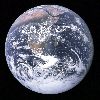

In [45]:
a = testimage("earth_apollo17")[1:end-2,:][2:3:end-1,2:3:end-1]
b = a[1:10:end-9,1:10:end-9]
    +a[2:10:end-8,2:10:end-8]
    +a[3:10:end-7,3:10:end-7]
    +a[4:10:end-6,4:10:end-6]
    +a[5:10:end-5,5:10:end-5]
    +a[6:10:end-4,6:10:end-4]
    +a[7:10:end-3,7:10:end-3]
    +a[8:10:end-2,8:10:end-2]
    +a[9:10:end-9,9:10:end-1]
    +a[10:10:end,10:10:end]